In [2]:
#importing Libraies
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

/opt/anaconda3/envs/python_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#load the dataset
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

#### Filter Data For Data Scientist in Indis

In [4]:
df_in = df[df['job_country'] == 'India']

#### Explod Skills
Converts the job_skills column from string representations of lists into actual list objects and then expands these lists so each skill appears in its own row. It then displays the job_title and job_skills columns, allowing us to analyze the distribution of skills across different data job titles.


In [5]:
df_skills = df_in.explode('job_skills')

df_skills[['job_title','job_skills']]

,job_title,job_skills
16,Big Data Engineer,powershell
16,Big Data Engineer,python
16,Big Data Engineer,sql
16,Big Data Engineer,mysql
16,Big Data Engineer,sql server
...,...,...
785716,Application Support Analyst,c#
785716,Application Support Analyst,sql
785718,Senior Performance QA Analyst,None
785740,AWS System Analyst,aws


#### Count Skills per Job Title
Groups DataFrame by job_skills and job_title_short, counting the occurrences of each skill within each job title.


In [6]:
df_skill_count = df_skills.groupby(['job_skills','job_title_short']).size()

df_skill_count = df_skill_count.reset_index(name='skill_count')
df_skill_count.sort_values(by='skill_count',ascending=False,inplace=True)
df_skill_count

,job_skills,job_title_short,skill_count
1374,sql,Data Engineer,12993
1088,python,Data Engineer,11568
1089,python,Data Scientist,9248
1327,spark,Data Engineer,7157
103,aws,Data Engineer,6993
...,...,...,...
389,esquisse,Data Scientist,1
887,node.js,Senior Data Analyst,1
753,matlab,Cloud Engineer,1
411,fastapi,Cloud Engineer,1


### Create List of Top 3 Roles
**Focus: Data Analysts, Data Engineers, and Data**

Filter the job title based on most popular

In [7]:
job_titles = df_skill_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

#### Plot Skill Count
Creates a stacked horizontal bar chart for the top 5 skills for Top 3 roles, displaying the frequency of each skill.

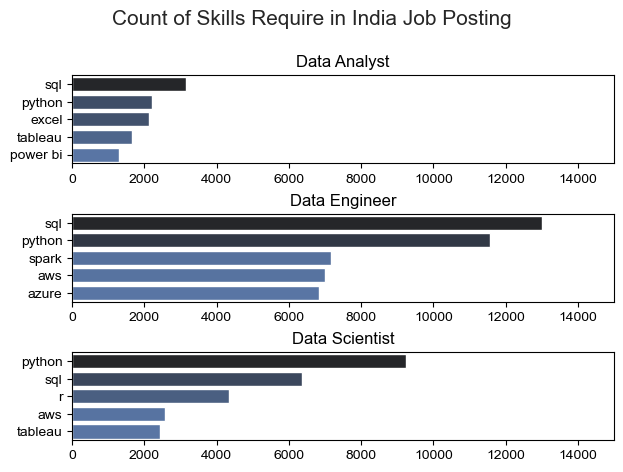

In [8]:
fig, ax = plt.subplots(len(job_titles),1)

sns.set_theme(style ='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skill_count[df_skill_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().set_visible(False)
    ax[i].set_xlim(0,15000)

fig.suptitle('Count of Skills Require in India Job Posting', fontsize=15)
fig.tight_layout(h_pad=0.5)
plt.show()


#### Convert Count into Percentages
**Focus: Counts don't show what portions of jobs are requesting these skills**

So we'll convert the counts into percentages which helps us understand how each job title represents relative to the entire dataset.

In [9]:
df_job_title_count = df_in['job_title_short'].value_counts().reset_index(name='job_total')
df_job_title_count

,job_title_short,job_total
0,Data Engineer,19062
1,Data Scientist,13279
2,Data Analyst,6121
3,Senior Data Engineer,4353
4,Senior Data Scientist,2486
5,Business Analyst,1887
6,Software Engineer,1795
7,Senior Data Analyst,1083
8,Machine Learning Engineer,671
9,Cloud Engineer,351


In [10]:
df_skill_perc = pd.merge(df_skill_count,df_job_title_count, on='job_title_short', how='left')

df_skill_perc['skill_percent'] = (df_skill_perc['skill_count']/df_skill_perc['job_total']) * 100

df_skill_perc

,job_skills,job_title_short,skill_count,job_total,skill_percent
0,sql,Data Engineer,12993,19062,68.161788
1,python,Data Engineer,11568,19062,60.686182
2,python,Data Scientist,9248,13279,69.643798
3,spark,Data Engineer,7157,19062,37.545903
4,aws,Data Engineer,6993,19062,36.685552
...,...,...,...,...,...
1684,esquisse,Data Scientist,1,13279,0.007531
1685,node.js,Senior Data Analyst,1,1083,0.092336
1686,matlab,Cloud Engineer,1,351,0.284900
1687,fastapi,Cloud Engineer,1,351,0.284900


#### Plot Percentage Count
Filters and sorts a DataFrame to get the top 5 skills percentages for these top 3 roles. After sorting the skills by descending percentage, reverse the order of these top 5 entries to use in a horizontal bar plot, which by default starts plotting from the bottom.

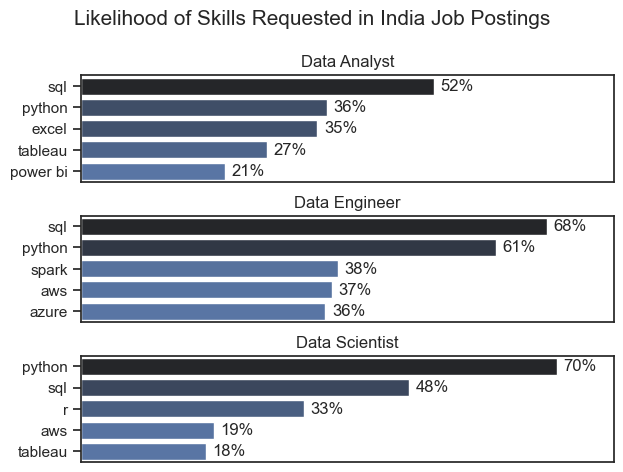

In [ ]:
fig, ax = plt.subplots(len(job_titles), 1)

    
for i, job_title in enumerate(job_titles):
    df_plot = df_skill_perc[df_skill_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().set_visible(False)
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_title) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in India Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.8)
plt.show()